## Basic Swarm Example

In [1]:
from src import Platform

config = {
    "data":{
        "path": "/mnt/ZOD",
        "version":"full",
        "ratio":0.005,
        "img_size": 160,
        "transforms":"[Resize(img_size)]",
        "shuffle_seed": 42,
        "decentralised_shuffle_seed": 42,
        "dataloader_args": {
            "batch_size": 32,
        },
        "train_val_id_generator":"balanced_frames",
        "dataset_getitem":"interpolated_target_distances",
    },
    "model":{
        "name": "ptnet",
        "args": {
            "num_output":51
        },
        "loss":"L1Loss"
    },
    "central":{
        "train":"false",
        "use_gpu":"true",
        "epochs": 100
    }
}

platform = Platform(config)

Loading train frames:   0%|          | 0/89976 [00:00<?, ?it/s]

Loading val frames:   0%|          | 0/10024 [00:00<?, ?it/s]

INFO flwr 2023-03-26 14:56:59,673 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
2023-03-26 14:57:01,777	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-03-26 14:57:02,149 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 16859314176.0, 'node:172.25.17.195': 1.0, 'CPU': 4.0, 'memory': 33718628352.0, 'GPU': 2.0, 'accelerator_type:RTX': 1.0}
INFO flwr 2023-03-26 14:57:02,151 | server.py:86 | Initializing global parameters
INFO flwr 2023-03-26 14:57:02,152 | server.py:270 | Requesting initial parameters from one random client
INFO flwr 2023-03-26 14:57:31,892 | server.py:274 | Received initial parameters from one random client
INFO flwr 2023-03-26 14:57:31,893 | server.py:88 | Evaluating initial parameters
INFO flwr 2023-03-26 14:57:46,496 | server.py:101 | FL starting
DEBUG flwr 2023-03-26 14:57:46,497 | server.py:215 | fit_round 1: strategy sample

In [6]:
from src import Platform

config = {
    "data":{
        "path": "/mnt/ZOD",
        "version":"full",
        "ratio":0.001,
        "img_size": [400, 1420],
        "transforms":"[CustomCrop(800, 500, 800, 2840), Resize((400, 1420))]",
        "shuffle_seed": 42,
        "decentralised_shuffle_seed": 42,
        "dataloader_args": {
            "batch_size": 32,
        },
        "train_val_id_generator":"balanced_frames",
        "dataset_getitem":"interpolated_target_distances",
    },
    "model":{
        "name": "ptnet",
        "args": {
            "num_output":51
        },
        "loss":"L1Loss"
    },
    "central":{
        "train":"true",
        "use_gpu":"true",
        "epochs": 100
    },
    "decentralised":{
        "train": [],
        "global":{
            "n_clients":3,
            "global_rounds":3,
            "client_resources":{
                "num_cpus": 1, 
                "num_gpus": 0.3
            },
            "ray_init_args":{
                "include_dashboard": True,
                "num_cpus": 4,
                "num_gpus": 2
            }
        },
        "client": {
            "epochs": 3
        }
    }
}

platform = Platform(config)

Loading train frames:   0%|          | 0/89976 [00:00<?, ?it/s]

Loading val frames:   0%|          | 0/10024 [00:00<?, ?it/s]

In [32]:
import numpy as np

from cv2 import circle
from zod.constants import Camera
from zod.utils.geometry import get_points_in_camera_fov, project_3d_to_2d_kannala, transform_points

def car_points_to_camera(zod_frames, frame_id, car_points):
    camera=Camera.FRONT
    frame = zod_frames[frame_id]
    calibs = frame.calibration
    # transform point to camera coordinate system
    T_inv = np.linalg.pinv(calibs.get_extrinsics(camera).transform)
    camera_points = transform_points(car_points[:, :3], T_inv)
    return camera_points

def camera_points_to_2d(zod_frames, frame_id, camera_points):
    camera=Camera.FRONT
    frame = zod_frames[frame_id]
    calibs = frame.calibration
    # filter points that are not in the camera field of view
    points_in_fov = get_points_in_camera_fov(calibs.cameras[camera].field_of_view, camera_points)
    
    # project points to image plane
    image_points = project_3d_to_2d_kannala(
        points_in_fov,
        calibs.cameras[camera].intrinsics[..., :3],
        calibs.cameras[camera].distortion,
    )
    return image_points

def get_image(zod_frames, frame_id):
    return zod_frames[frame_id].get_image()

def draw_circles(image, image_points, colour=(255, 0, 0)):
    for i in range(image_points.shape[0]):
        x, y = int(image_points[i, 0]), int(image_points[i, 1])
        circle(image, (x,y), 20, colour, -1)
    return image

def visualize_car_points(zod_frames, frame_id, car_points, colour=(255, 0, 0), image=None):
    camera_points = car_points_to_camera(zod_frames, frame_id, car_points)
    image_points = camera_points_to_2d(zod_frames, frame_id, camera_points)
    if image is None:
        image = get_image(zod_frames, frame_id)
    image = draw_circles(image, image_points, colour)
    return image

In [80]:
import torch
from src.utils.models.model_manager import load_model_from_name
import matplotlib.pyplot as plt

# Define the device to be used (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the path to the saved model checkpoint
model_path = 'runs/2023-03-26_19:16:54/centralised_ptnet.pth'

# Load the model checkpoint
model_params = torch.load(model_path)

# Load the model
model = load_model_from_name("ptnet", num_output=51)
model.load_state_dict(model_params)

# Set the model to evaluation mode
model.eval()

# Move the model to the specified device
model.to(device)

def plot(idx):
    # Define the input to the model
    input_tensor, ground_truth = platform.data.central.train.dataset[idx]

    # Move the input tensor to the specified device
    input_tensor = input_tensor.unsqueeze(0).to(device)

    # Disable autograd to speed up inference
    with torch.no_grad():

        # Pass the input through the model to get the output
        output = model(input_tensor)

    # Convert the output to a numpy array
    output = output.cpu().numpy()
    output = output.reshape(17, 3)
    ground_truth = ground_truth.reshape(17, 3)

    frame_id = platform.data.central.train.dataset.frames_id_set[idx]
    zod_frames = platform.data.central.train.dataset.zod_frames

    #image_with_ground_truth = visualize_car_points(zod_frames, frame_id, ground_truth, colour=(255, 0, 0))
    image_with_gt = visualize_car_points(zod_frames, frame_id, ground_truth, colour=(0, 0, 255))
    image_with_prediction = visualize_car_points(zod_frames, frame_id, output, colour=(255, 0, 0), image=image_with_gt)

    loss = torch.nn.L1Loss()(torch.tensor(output).squeeze(), torch.tensor(ground_truth))
    print("Loss: {}".format(loss))
    return image_with_prediction, loss.item()


Loss: 1.20192551612854
Loss: 5.978120803833008
Loss: 10.64299488067627
Loss: 0.6139122247695923
Loss: 9.061573028564453
Loss: 1.1543195247650146
Loss: 5.850682735443115
Loss: 0.575593888759613
Loss: 23.020952224731445
Loss: 6.610623836517334
Loss: 4.173903465270996
Loss: 2.6311120986938477
Loss: 22.88201332092285
Loss: 3.94455623626709
Loss: 4.0958571434021
Loss: 29.02103042602539
Loss: 2.862320899963379
Loss: 1.5184437036514282
Loss: 1.4099761247634888
Loss: 2.7127506732940674
Loss: 0.865740180015564
Loss: 21.353912353515625
Loss: 2.9769153594970703
Loss: 4.236838340759277
Loss: 1.1230899095535278
Loss: 3.3159334659576416
Loss: 2.5012893676757812
Loss: 1.5811471939086914
Loss: 1.0605446100234985
Loss: 2.194390296936035
Loss: 2.2763261795043945
Loss: 6.011280059814453
Loss: 0.9983968734741211
Loss: 0.7199443578720093
Loss: 2.004554510116577


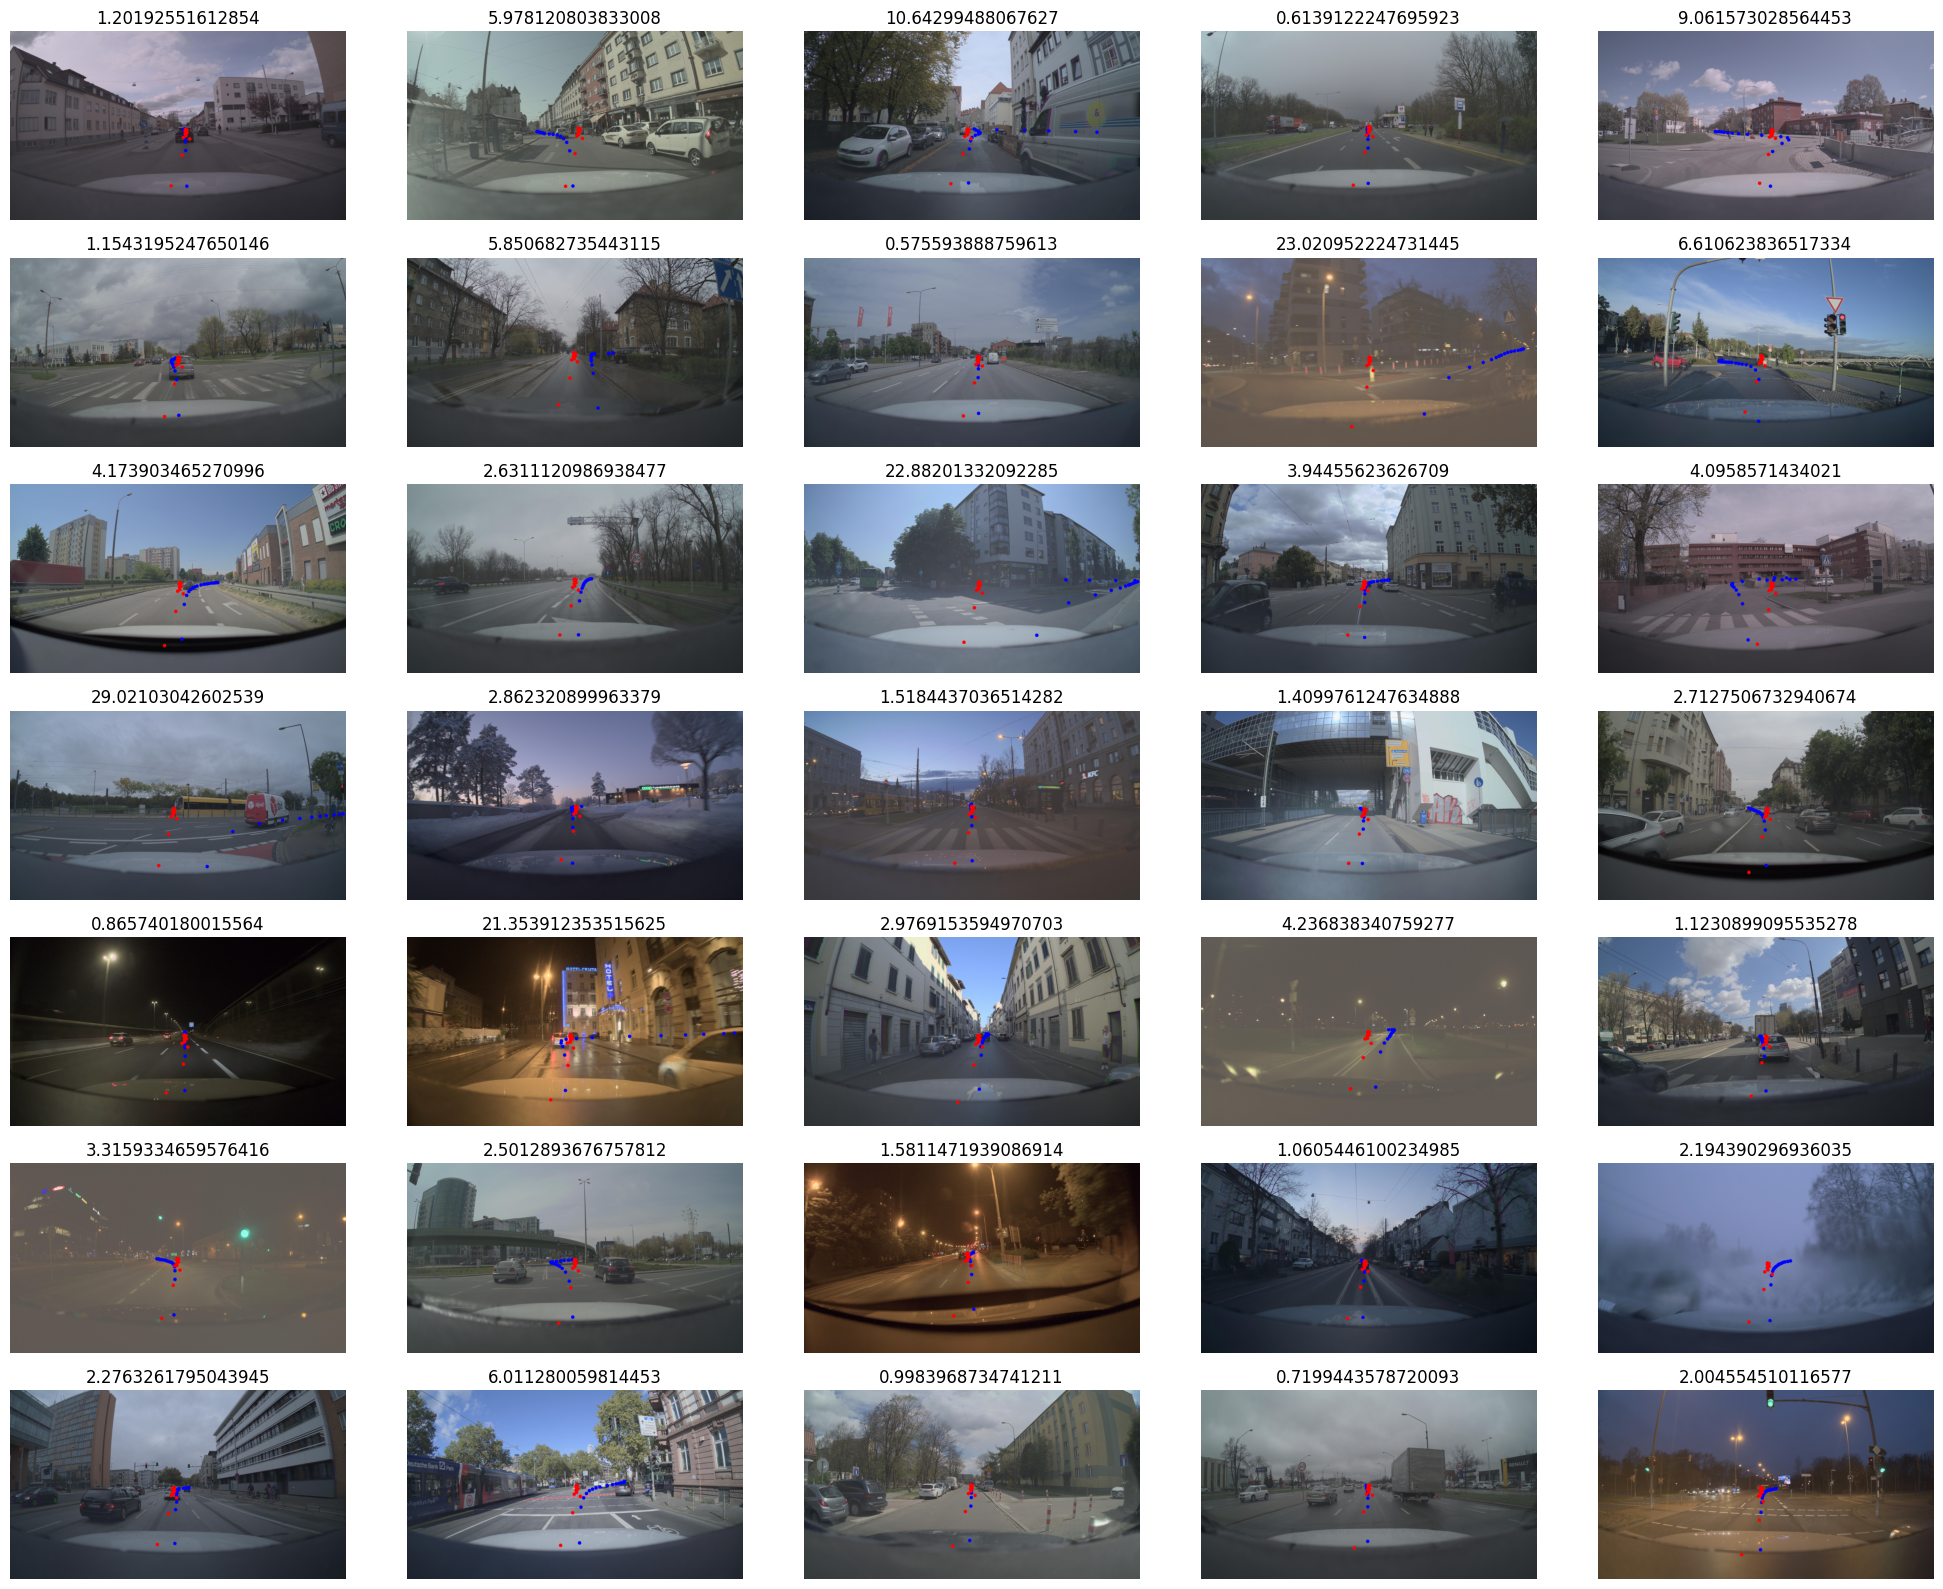

In [81]:
import matplotlib.pyplot as plt

def plot_images(ids):
    fig, axs = plt.subplots(7, 5, figsize=(20, 16))
    
    for i, ax in enumerate(axs.flat):
        if i < len(ids):
            img, title = plot(ids[i])
            ax.imshow(img)
            ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_images([*range(0, 35)])

012589


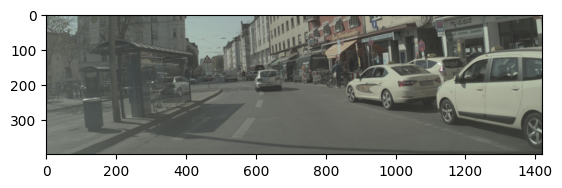

In [97]:
i = 1
image, gt = platform.data.central.train.dataset[i]
frame_id = platform.data.central.train.dataset.frames_id_set[i]
image = np.transpose(image.cpu().numpy(), (1, 2, 0))

print(frame_id)
plt.imshow(image.astype(np.uint8))
plt.show()

In [1]:
from src import Platform

config = {
    "data":{
        "path": "/mnt/ZOD",
        "version":"full",
        "ratio":1,
        "img_size": 160,
        "transforms":"[Resize(img_size)]",
        "shuffle_seed": 42,
        "decentralised_shuffle_seed": 42,
        "dataloader_args": {
            "batch_size": 32,
        },
        "train_val_id_generator":"overfit_turn",
        "dataset_getitem":"interpolated_target_distances",
    },
    "model":{
        "name": "ptnet",
        "args": {
            "num_output":51
        },
        "loss":"L1Loss"
    },
    "central":{
        "train":"true",
        "use_gpu":"true",
        "epochs": 100
    },
    "decentralised":{
        "train": [],
        "global":{
            "n_clients":3,
            "global_rounds":3,
            "client_resources":{
                "num_cpus": 1, 
                "num_gpus": 0.3
            },
            "ray_init_args":{
                "include_dashboard": True,
                "num_cpus": 4,
                "num_gpus": 2
            }
        },
        "client": {
            "epochs": 3
        }
    }
}

platform = Platform(config)

Loading train frames:   0%|          | 0/89976 [00:00<?, ?it/s]

Loading val frames:   0%|          | 0/10024 [00:00<?, ?it/s]

/home/alex/miniconda3/envs/swarm/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1, 51])) that is different to the input size (torch.Size([51])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/alex/miniconda3/envs/swarm/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alex/miniconda3/envs/swarm/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
